In [1]:
import numpy as np
import scipy
import astropy
import matplotlib.pyplot as plt
import datetime
from dateutil import parser
import pandas as pd
from astropy.time import Time
import gc
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
import scipy.stats as st
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp
# import matplotlib.style as style
# style.use('seaborn-dark-palette')
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
def fold_data(period, ref_mjd, mjds, no_cycle=True):
    phase = (mjds-ref_mjd) / period
    if no_cycle:
        phase = phase % 1
    return phase

def get_poisson_error(r, conf_level=0.68):
    low_lim = 0.5 * chi2.ppf((1 - conf_level) / 2, 2 * r)
    if low_lim.size > 1:
        low_lim[np.isnan(low_lim)] = 0 
    upp_lim = 0.5 * chi2.ppf((1 + conf_level) / 2, 2 * (r+1))
    if upp_lim.size > 1:
        upp_lim[np.isnan(upp_lim)] = 0
    return low_lim, upp_lim

def get_phase_exposure(exp, obs_phase, nbin=None):
    ''' Use nbin if you want exposure between phase of 0 and 1, where nbin represents number of bins in histogram'''
    if nbin is None:
        max_cycle = int(np.max(obs_phase))
        exp_phase = np.zeros(max_cycle)
        for j in range(max_cycle):
            e = 0
            for i in range(len(obs_phase)):
                if j < obs_phase[i] < j+1:
                    e = e + exp[i]
            exp_phase[j] = e
    else:
        n=np.linspace(0,1,nbin)
        #exp_phase = np.zeros(len(n))
        exp_phase = np.zeros(len(n)-1)
        #for j in range(len(n)):
        for j in range(len(n)-1):
            e = 0
            for i in range(len(obs_phase)):
                if n[j] < obs_phase[i] < n[j+1]:
                    e = e + exp[i]
            exp_phase[j] = e 
            
    return exp_phase


def get_phase_sens(sens, obs_phase, nbin=None):    
    if nbin is None:
        max_cycle = int(np.max(obs_phase))
        sens_phase = np.zeros(max_cycle)
        for j in range(max_cycle):
            x =[]
            for i in range(len(obs_phase)):
                if j < obs_phase[i] < j+1:
                    x.append(sens[i])
            x = np.array(x)
            sens_phase[j] = np.nanmean(x)
    else:
        n=np.linspace(0,1,nbin)
        #sens_phase = np.zeros(len(n))
        sens_phase = np.zeros(len(n)-1)
        #for j in range(len(n)):
        for j in range(len(n)-1):
            x = []
            for i in range(len(obs_phase)):
                if n[j] < obs_phase[i] < n[j+1]:
                    x.append(sens[i])
            x = np.array(x)
            sens_phase[j] = np.nanmean(x)
            
    return sens_phase

def scale_rate(rate, thresh, ref_thresh=5.2, gamma=-2.3):
    rate_thresh = rate*((ref_thresh/thresh)**(gamma+1))
    return rate_thresh
    

In [3]:
#### Loading Data #####
data_all = np.load('/Users/ketansand/Downloads/All_R3_events.npz', allow_pickle=True)
data_remove = np.load('/Users/ketansand/Downloads/R3_after_excision_new.npz', allow_pickle=True)
#data_remove = np.load('/Users/ketansand/Notebooks/R3_after_excision_pragya.npz', allow_pickle=True)
exp = np.load('/Users/ketansand/Downloads/exposure_29.503_65.717_res_4s_src_R3.npz', allow_pickle=True)

event_all = data_all["Events"]
date_all = data_all["Dates"]
date_all_r = []

for d in date_all:
    ds = parser.parse(d)
    np.array(date_all_r.append(ds))
    
# for i in range(len(event_all)):
#     print(event_all[i], date_all_r[i])
    

event_remove = data_remove["Events"]
date_remove = data_remove["Dates"]

exp_u = exp["exp_mins_u"]
sens_u = exp['psr_rel_sens_u']
print("Total Exposure = ", np.sum(exp_u)/60)
date_list = exp["datelist"]
obs_dates = Time(date_list, format='datetime', scale='utc')

Total Exposure =  201.03222222222223


In [4]:
x = get_poisson_error(40, 0.95)
exp_60 = np.sum(exp_u)/60
x_low = (40/exp_60) - (x[0]/exp_60)
x_high = (x[1]/exp_60) - (40/exp_60) 
print(x)
print(x_low, 40/exp_60, x_high)


##### For SGR ######

print("For SGR")

x_sg = get_poisson_error(3,0.95)
exp_sg = 627 ## in days
x_sg_low = (3/exp_sg) - (x_sg[0]/exp_sg)
x_sg_high = (x[1]/exp_sg) - (3/exp_sg) 
print(x_sg)
print(x_sg_low, 3/exp_sg, x_sg_high)


(28.576586441788965, 54.468646963984064)
0.0568237938771006 0.19897307783716264 0.07197178046408068
For SGR
(0.6186721228956015, 8.767273069742323)
0.003797971095860285 0.004784688995215311 0.08208715624239883


In [5]:
#### Removing dates beyond limit of 31st December 2021 ####
limit = datetime.datetime(2021, 12, 31, 11, 59, 59)
date_all = []
for i in range(len(date_all_r)):
    if date_all_r[i] < limit:
        np.array(date_all.append(date_all_r[i])) 

In [6]:
###### Final data products #####
date_all = date_all
date_remove = date_remove

##### Converting to MJD #####
t_all = Time(date_all, format='datetime', scale='utc')
t_remove = Time(date_remove, format='datetime', scale='utc')
print(t_all.shape, t_remove.shape)
mjd_all = t_all.mjd
mjd_remove  = t_remove.mjd
mjd_obs_dates = obs_dates.mjd

(94,) (39,)


The following will involve 3 plots and corresponding analysis

1. The burst count analysis - This will involve all the bursts detected in their respective cycle. Since we are just looking at count statistics and not calculating the rate, we will not excise any bursts. Regardless whether it was detected outside FWHM or on days with zero-exposure and low sensitivity. We will do a check to see whether burst count is poissonian or not. 
2. The rate analysis with cycle - This will involve all the excised bursts, since we are doing a rate calculation. Double check the excised bursts with Pragya.
3. Rate analysis with Phase - This will include all the excised bursts. 

[1 0 1 2 2 0 4 0 1 0 0 0 0 0 0 5 4 0 0 0 2 3 0 0 0 2 0 0 3 2 1 5 3 0 1 0 2
 2 0 2 1 2 1 0 2 1 0 1 0 1 0 0 1 5 1 5 1 1 0 0 2 0 2 4 0 2 1 0 3 0 4 1 2 2]
[124.46666667  62.33333333 187.          99.73333333 183.73333333
  86.8        198.26666667 186.         186.4        201.4
 184.06666667 124.53333333 173.6        210.8         37.2
  83.33333333 137.13333333 111.6         93.46666667 128.
 167.46666667 174.33333333 173.93333333 136.4        111.73333333
 136.53333333 136.4         99.6        174.66666667 210.8
 187.4        174.53333333 198.93333333 192.86666667 185.73333333
 186.73333333 187.         198.73333333 111.73333333 199.8
 183.26666667 212.2        184.46666667 161.33333333 169.66666667
 187.6        161.66666667  49.6         99.73333333 200.06666667
 212.2        173.8        200.33333333 199.4        212.
 199.53333333 111.93333333 159.53333333 200.53333333 166.86666667
 170.26666667 174.13333333 109.53333333 139.8        150.13333333
 199.8        179.33333333 175.1333

<ipython-input-10-dfca4a002ad1>:61: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_all, x])
<ipython-input-10-dfca4a002ad1>:61: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_all, x])
<ipython-input-10-dfca4a002ad1>:61: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_all, x])
<ipython-input-10-dfca4a002ad1>:61: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_all, x])
<ipython-input-10-dfca4a002ad1>:61: UserWarning: p-value floored: true value smaller than 0.001
  ad = anderson_ksamp([burst_count_all, x])
<ipython-input-10-dfca4a002ad1>:61: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_all, x])
<ipython-input-10-dfca4a002ad1>:61: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_all, x])
<ipython-input-10-dfca4a002ad1>:61: Us

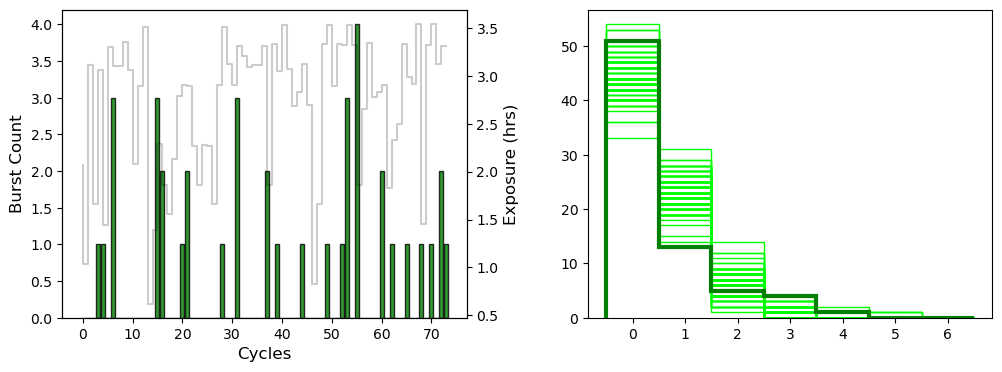

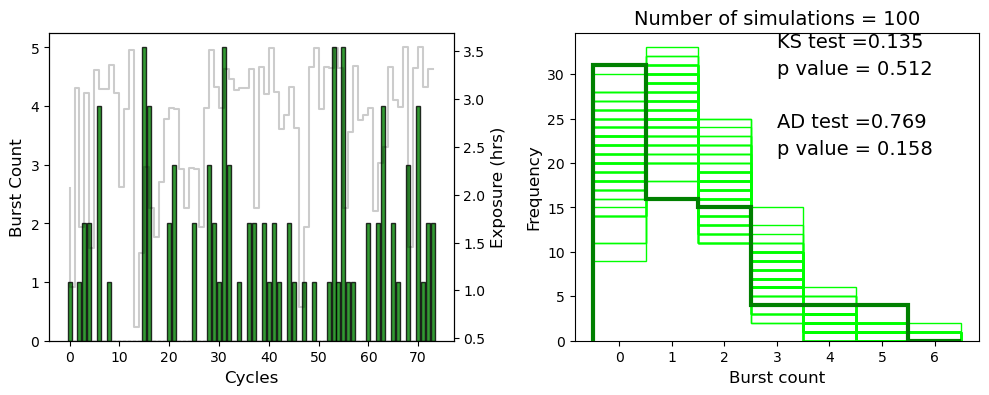

<ipython-input-10-dfca4a002ad1>:132: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_remove, x])
<ipython-input-10-dfca4a002ad1>:132: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_remove, x])
<ipython-input-10-dfca4a002ad1>:132: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_remove, x])
<ipython-input-10-dfca4a002ad1>:132: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_remove, x])
<ipython-input-10-dfca4a002ad1>:132: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_remove, x])
<ipython-input-10-dfca4a002ad1>:132: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_remove, x])
<ipython-input-10-dfca4a002ad1>:132: UserWarning: p-value capped: true value larger than 0.25
  ad = anderson_ksamp([burst_count_remove, x])
<ipython-inpu

KS test = 0.0945945945945946, p value = 0.8981908045103704
KS test = 0.04054054054054054, p value = 0.9999999942141572
KS test = 0.21621621621621623, p value = 0.06266342411553422
Median of p is 0.8981908045103704
For anderson darling
Median value -0.00748125549051638
Median p value 0.25


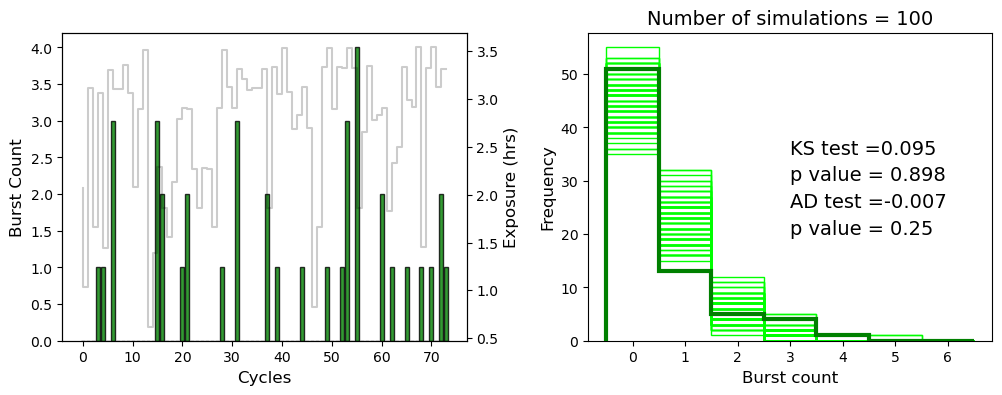

In [10]:
#### The count analysis #####

ref_mjd = 58369.40
period = 16.33

phase_cycle_burst = fold_data(period, ref_mjd, mjd_all, False)

phase_cycle_burst_ex = fold_data(period, ref_mjd, mjd_remove, False)

phase_cycle_obs = fold_data(period, ref_mjd, mjd_obs_dates, False)

obs_phases_cycle =  np.copy(phase_cycle_obs) ### Phases in each cycle ###

exp_per_cycle = get_phase_exposure(exp_u, obs_phases_cycle)

max_cycle = int(np.max(phase_cycle_obs))

#### All the bursts #####

burst_count_all = []

for i in range(0,max_cycle):
    count = 0
    for j in range(len(phase_cycle_burst)):
        if i < phase_cycle_burst[j] < i+1:
            count = count + 1
    i = i + 1
    burst_count_all.append(count)

burst_count_all = np.array(burst_count_all)
print(burst_count_all)
print(exp_per_cycle)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'wspace': 0.3}) ### Plotting count per cycle ####

#fig.suptitle("All burst count distribution", fontsize = 14)
x_all = np.arange(0,len(burst_count_all),1)
ax1.bar(x_all,burst_count_all, alpha = 0.8, linewidth = 1, edgecolor='k', color='green')
ax11 = ax1.twinx()
ax11.step(x_all, exp_per_cycle/60, color='k',alpha=0.2)
ax1.set_xlabel("Cycles", fontsize=12)
ax1.set_ylabel("Burst Count", fontsize=12)
ax11.set_ylabel("Exposure (hrs)", fontsize=12)

         ##### Doing the simulation #####
nc = np.arange(0,8) - 0.5
ax2.hist(burst_count_all, bins=nc, density=False, histtype='step', color='green', zorder=90, linewidth=3)

print("The mean rate is", np.mean(burst_count_all))

nsim = 100
ks_val = np.zeros(nsim)
ad_val = np.zeros(nsim)
p_val_ad = np.zeros(nsim)
p_val = np.zeros(nsim)
for i in range(nsim):
    x = poisson.rvs(mu=np.mean(burst_count_all), size=max_cycle)
    hist2 = ax2.hist(x, bins=nc, density=False, histtype='step',color='lime')#alpha=1)
    ks = ks_2samp(burst_count_all, x)
    ad = anderson_ksamp([burst_count_all, x])
    ks_val[i] = ks[0]
    p_val[i] = ks[1]
    ad_val[i] = ad[0]
    p_val_ad[i] = ad[2]


med_ind = np.where(np.median(ks_val) == ks_val)
med_p = np.median(p_val) 
low_ind = np.where(np.min(ks_val) == ks_val)
high_ind = np.where(np.max(ks_val) == ks_val)

print("KS test = {}, p value = {}".format(ks_val[med_ind][0], p_val[med_ind][0]))
print("KS test = {}, p value = {}".format(ks_val[low_ind][0], p_val[low_ind][0]))
print("KS test = {}, p value = {}".format(ks_val[high_ind][0], p_val[high_ind][0]))
print("Median of p is", med_p)



print("For anderson darling")

print("Median value", np.median(ad_val))
print("Median p value", np.median(p_val_ad))


ax2.text(3,33,"KS test ={}".format(ks_val[med_ind][0].round(3)), fontsize=14)
ax2.text(3,30,"p value = {}".format(p_val[med_ind][0].round(3)), fontsize=14)
ax2.text(3,24,"AD test ={}".format(np.median(ad_val).round(3)), fontsize=14)
ax2.text(3,21,"p value = {}".format(np.median(p_val_ad).round(3)), fontsize=14)
ax2.set_title("Number of simulations = {}".format(nsim), fontsize=14)
    
ax2.set_xlabel("Burst count", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
oname = "Final_plots/All_bursts_count_nodensity_AD_KS_exposure_added.pdf"
plt.savefig(oname, dpi=300, bbox_inches ='tight')
plt.show()

#### Excised bursts ########################

burst_count_remove = []

for i in range(0,max_cycle):
    count = 0
    for j in range(len(phase_cycle_burst_ex)):
        if i < phase_cycle_burst_ex[j] < i+1:
            count = count + 1
    i = i + 1
    burst_count_remove.append(count)

burst_count_remove = np.array(burst_count_remove)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4), gridspec_kw={'wspace': 0.3})
#fig.suptitle("Excised burst count distribution", fontsize = 14)
x_all = np.arange(0,len(burst_count_remove),1)
ax1.bar(x_all,burst_count_remove, alpha = 0.8, linewidth = 1, edgecolor='k', color='green')
ax11 = ax1.twinx()
ax11.step(x_all, exp_per_cycle/60, color='k',alpha=0.2)
ax1.set_xlabel("Cycles", fontsize=12)
ax1.set_ylabel("Burst Count", fontsize=12)
ax11.set_ylabel("Exposure (hrs)", fontsize=12)
nc = np.arange(0,8) - 0.5
ax2.hist(burst_count_remove, bins=nc, density=False, histtype='step', color='green', zorder=90, linewidth=3)

ks_val = np.zeros(nsim)
p_val = np.zeros(nsim)
ad_val = np.zeros(nsim)
p_val_ad = np.zeros(nsim)
for i in range(nsim):
    x = poisson.rvs(mu=np.mean(burst_count_remove), size=max_cycle)
    hist2 = ax2.hist(x, bins=nc, density=False, histtype='step',color='lime')#alpha=1)
    ks = ks_2samp(burst_count_remove, x)
    ad = anderson_ksamp([burst_count_remove, x])
    ks_val[i] = ks[0]
    p_val[i] = ks[1]
    ad_val[i] = ad[0]
    p_val_ad[i] = ad[2]

med_ind = np.where(np.median(ks_val) == ks_val)
med_p = np.median(p_val) 
low_ind = np.where(np.min(ks_val) == ks_val)
high_ind = np.where(np.max(ks_val) == ks_val)

print("KS test = {}, p value = {}".format(ks_val[med_ind][0], p_val[med_ind][0]))
print("KS test = {}, p value = {}".format(ks_val[low_ind][0], p_val[low_ind][0]))
print("KS test = {}, p value = {}".format(ks_val[high_ind][0], p_val[high_ind][0]))
print("Median of p is", med_p)

print("For anderson darling")

print("Median value", np.median(ad_val))
print("Median p value", np.median(p_val_ad))


ax2.text(3,35,"KS test ={}".format(ks_val[med_ind][0].round(3)), fontsize=14)
ax2.text(3,30,"p value = {}".format(p_val[med_ind][0].round(3)), fontsize=14)
ax2.text(3,25,"AD test ={}".format(np.median(ad_val).round(3)), fontsize=14)
ax2.text(3,20,"p value = {}".format(np.median(p_val_ad).round(3)), fontsize=14)
ax2.set_title("Number of simulations = {}".format(nsim), fontsize=14)

ax2.set_xlabel("Burst count", fontsize=12)
ax2.set_ylabel("Frequency", fontsize=12)
oname = "Final_plots/Excise_burst_count_nodensity_AD_KS_exposure_added.pdf"
plt.savefig(oname, dpi=300, bbox_inches='tight')
plt.show()

# x = st.kstest(burst_count_all, 'poisson', args=(1,0))
# print(x)

0.1946365998877239 2.191256120158855
(27.732812489436476, 53.31428386583284)
0.19520387960759014 0.07164624985679238 0.05639483882892782


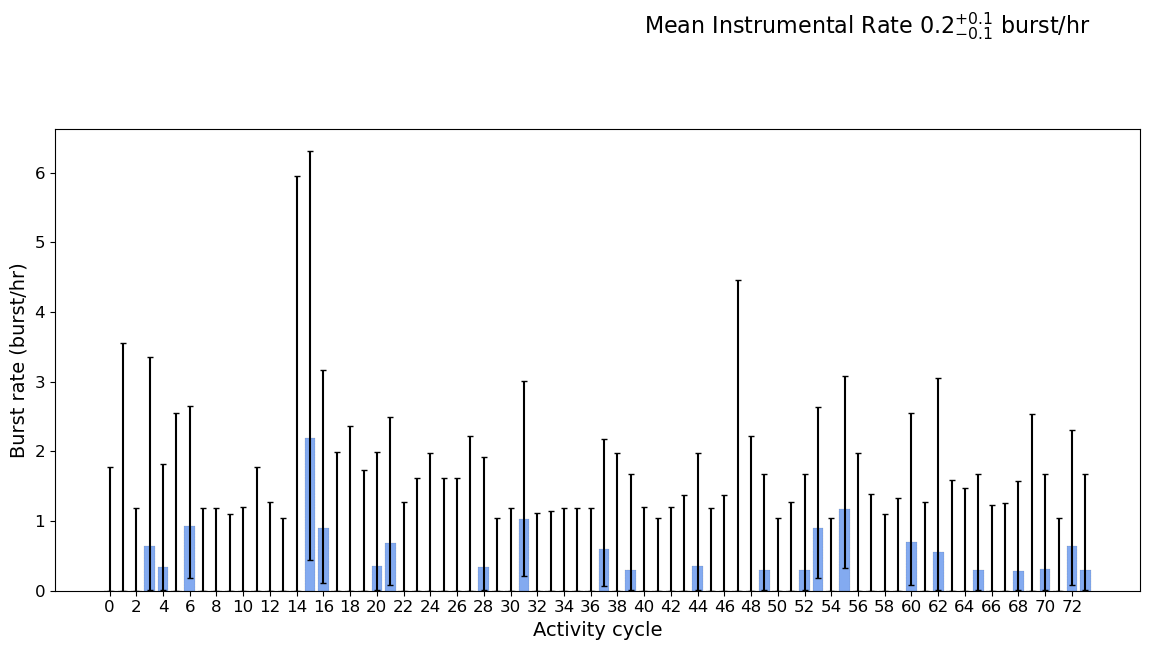

In [35]:
#### Rate vs cycle. Here we will only use excised bursts ####

obs_phases_cycle =  np.copy(phase_cycle_obs) ### Phases in each cycle ###

exp_per_cycle = get_phase_exposure(exp_u, obs_phases_cycle)

sens_per_cycle = get_phase_sens(sens_u, obs_phases_cycle)
sens_overall = np.nanmean(sens_u)
f_thresh = (sens_per_cycle/sens_overall) * 5.2  ####Getting sensitivity w.r.t to 5.2 Jy ms####

exp_per_cycle = exp_per_cycle/60 #### Converting to hours ######

bc_remove = np.copy(burst_count_remove) #### Getting the burst count in each cycle ####
#bc_remove = np.copy(burst_count_all)
rate_per_cycle = bc_remove/(exp_per_cycle)

##### Adjustting the rate to 5.2 Jy ms#####
rate_per_cycle = scale_rate(rate_per_cycle,f_thresh)

#print(bc_remove, get_poisson_error(bc_remove, conf_level=0.95))

rate_per_cycle_low = rate_per_cycle - (get_poisson_error(bc_remove, conf_level=0.95)[0])/exp_per_cycle
rate_per_cycle_high = (get_poisson_error(bc_remove, conf_level=0.95)[1])/exp_per_cycle - rate_per_cycle

combine_err = np.array(list(zip(rate_per_cycle_low, rate_per_cycle_high))).T

print(np.mean(rate_per_cycle), np.max(rate_per_cycle))

plt.figure(figsize=(14,6))

x = np.arange(0,len(bc_remove),1)
plt.bar(x,rate_per_cycle, yerr=combine_err, capsize=2, 
        alpha = 0.8, linewidth = 0.1, linestyle='--', edgecolor='k', color='cornflowerblue')

plt.xticks(np.arange(min(x), max(x)+1, 2.0), fontsize = 12)
plt.yticks(fontsize=12)

mean_rate = np.sum(bc_remove)/np.sum(exp_per_cycle)
pois = get_poisson_error(np.sum(bc_remove), 0.95)
print(pois)
mean_lower =  mean_rate - (pois[0]/np.sum(exp_per_cycle))
mean_upper = (pois[1]/np.sum(exp_per_cycle)) - mean_rate

# mean_rate = round(np.mean(rate_per_cycle),1)
# mean_upper = round(np.mean(rate_per_cycle_high),1)
# mean_lower = round(np.mean(rate_per_cycle_low),1)

plt.text(x = 40, y=8 , s=r"Mean Instrumental Rate ${}^{{+{}}}_{{-{}}}$ burst/hr".format(round(mean_rate,1), round(mean_upper,1), round(mean_lower,1)), fontsize= 16)
print(mean_rate, mean_upper, mean_lower)
plt.xlabel("Activity cycle", fontsize = 14)
plt.ylabel("Burst rate (burst/hr)", fontsize = 14)
#plt.savefig("Final_plots/ratevscycle_all.pdf", bbox_inches ='tight', dpi=300)
plt.show()

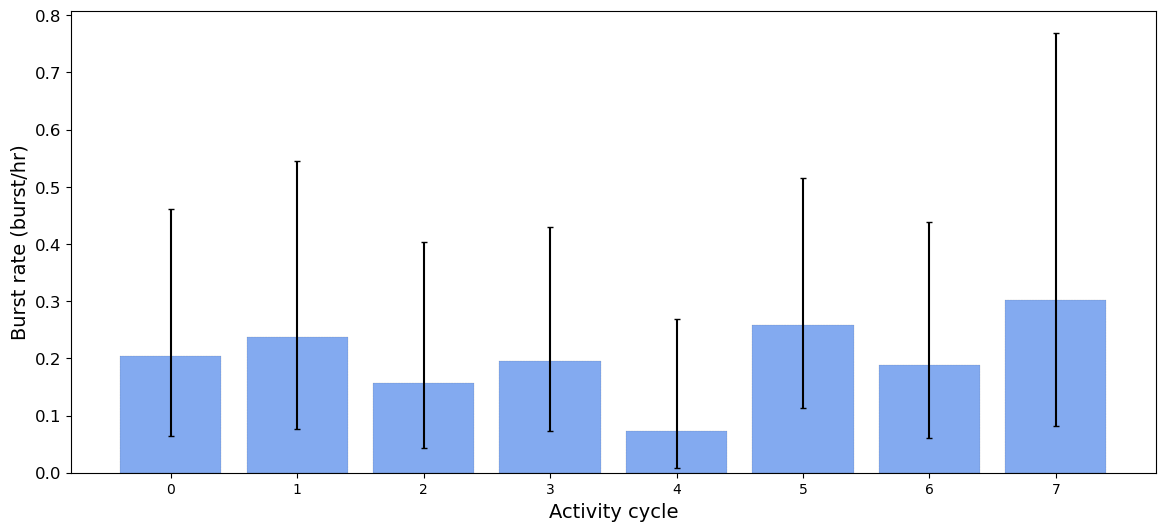

In [36]:
### Doing the analysis by combining cycles #####

sum_count = []
sum_exposure = []
mean_sens = []

c = 10

n = int(max_cycle/c)+1

for i in range(0,n):
    x = np.sum(bc_remove[i*c:(i+1)*c])
    sum_count.append(x)
    y = np.sum(exp_per_cycle[i*c:(i+1)*c])
    sum_exposure.append(y)
    z = np.mean(sens_per_cycle[i*c:(i+1)*c])
    mean_sens.append(z)
    
    
sum_count = np.array(sum_count)
sum_exposure = np.array(sum_exposure)
mean_sens = np.array(mean_sens)

sum_rate = sum_count/sum_exposure

sum_thresh = (mean_sens/sens_overall) * 5.2 

# print(sum_thresh)

sum_rate = scale_rate(sum_rate,sum_thresh)

sum_rate_lower = sum_rate - (get_poisson_error(sum_count, conf_level=0.95)[0])/sum_exposure
sum_rate_higher = (get_poisson_error(sum_count, conf_level=0.95)[1])/sum_exposure - sum_rate

combine_sum_err = np.array(list(zip(sum_rate_lower, sum_rate_higher))).T

# print(sum_rate_lower)
# print(sum_rate)
# print(sum_rate_higher)


plt.figure(figsize=(14,6))

x = np.arange(0,len(sum_count),1)
plt.bar(x,sum_rate, yerr=combine_sum_err, capsize=2, 
        alpha = 0.8, linewidth = 0.1, linestyle='--', edgecolor='k', color='cornflowerblue')

#plt.xticks(np.arange(min(x), max(x)+1, 2.0), fontsize = 12)
plt.yticks(fontsize=12)

plt.xlabel("Activity cycle", fontsize = 14)
plt.ylabel("Burst rate (burst/hr)", fontsize = 14)
# plt.savefig("Final_plots/ratevscycle_excised.pdf", bbox_inches ='tight', dpi=300)
plt.show()

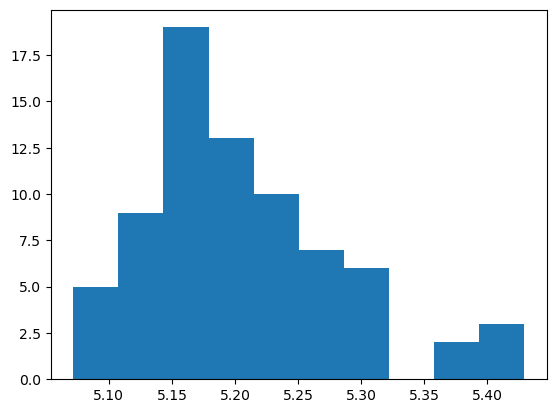

In [37]:
sens_per_cycle = get_phase_sens(sens_u, obs_phases_cycle)
sens_overall = np.nanmean(sens_u)
f_thresh = (sens_per_cycle/sens_overall) * 5.2
plt.hist(f_thresh)
plt.show()

16
19.60666666666667
0.3496064712525571 0.8160489629377762 0.5091634272812448
18
20.964444444444446
0.3497378258236392 0.8585965656137374 0.4983561713363994
Combined rate of left and mid 0.2576713165877459 0.8380347264063098 0.33303480543579933
5
20.5
0.1647079809698331 0.24390243902439024 0.32528449167427664


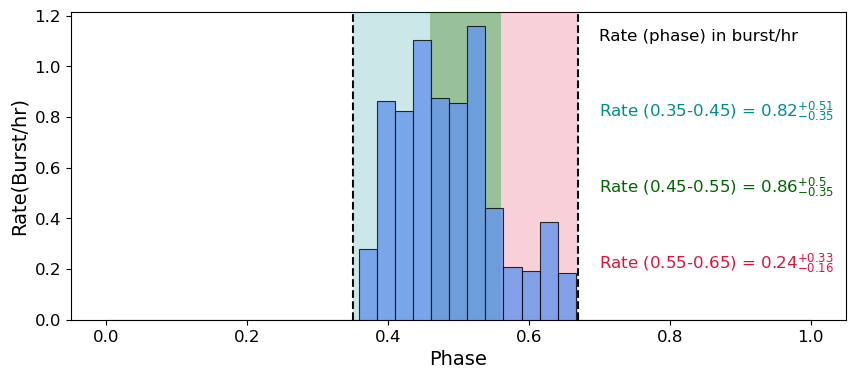

In [38]:
##### Phase vs cycle #####
obs_phases = fold_data(period, ref_mjd, mjd_obs_dates, True) #### Phases between 0 and 1
#nbin = 41
nbin = 40
exp_phases = get_phase_exposure(exp_u, obs_phases, nbin)
#print(exp_phases)

sens_phases = get_phase_sens(sens_u, obs_phases, nbin)
#sens_phases = sens_phases[0:nbin-1]
sens_phases = sens_phases[0:nbin]

f_thresh_phases = (sens_phases/sens_overall) * 5.2


#exp_phases = (exp_phases[0:nbin-1])/60
exp_phases = (exp_phases[0:nbin])/60

burst_phases = fold_data(period, ref_mjd, mjd_remove, True)
#burst_phases = fold_data(period, ref_mjd, mjd_all, True)

n=np.linspace(0,1,nbin)
bin_width = n[1]-n[0]


hist = np.histogram(burst_phases, bins=n)
# for i in range(len(hist[0])):
#     print(hist[0][i], hist[1][i])

rate_phases = hist[0]/exp_phases
### Scaling the phase to 5.2 Jy ms #####
rate_phases = scale_rate(rate_phases,f_thresh_phases)


rate_phases_low = rate_phases - (get_poisson_error(hist[0], conf_level=0.95)[0])/exp_phases
rate_phases_high = (get_poisson_error(hist[0], conf_level=0.95)[1])/exp_phases - rate_phases

##### Calculating rates at each phase range along with errors ####

left_ind = np.where(np.logical_and(n>=0.35, n<=0.45))
mid_ind = np.where(np.logical_and(n>=0.45, n<=0.55))
right_ind = np.where(np.logical_and(n>=0.55, n<=0.65))

#### Left range #######

lmin, lmax = np.min(left_ind), np.max(left_ind)+1
burst_l = np.sum(hist[0][lmin:lmax])
print(burst_l)
exp_l = np.sum(exp_phases[lmin:lmax])
print(exp_l)

ratel_val = burst_l/exp_l
ratel_lo = ratel_val - (get_poisson_error(burst_l, conf_level=0.95)[0])/exp_l
ratel_hi = (get_poisson_error(burst_l, conf_level=0.95)[1])/exp_l - ratel_val 
print(ratel_lo, ratel_val, ratel_hi)

# ratel_lo, ratel_val, ratel_hi = np.mean(rate_phases_low[lmin:lmax]), np.mean(rate_phases[lmin:lmax]), np.mean(rate_phases_high[lmin:lmax])
# print(ratel_lo, ratel_val, ratel_hi, "\n")

#### middle range #####

mmin, mmax = np.min(mid_ind), np.max(mid_ind)+1
burst_m = np.sum(hist[0][mmin:mmax])
print(burst_m)
exp_m = np.sum(exp_phases[mmin:mmax])
print(exp_m)

ratem_val = burst_m/exp_m
ratem_lo = ratem_val - (get_poisson_error(burst_m, conf_level=0.95)[0])/exp_m
ratem_hi = (get_poisson_error(burst_m, conf_level=0.95)[1])/exp_m - ratem_val 
print(ratem_lo, ratem_val, ratem_hi)

burst_ml = np.sum(hist[0][lmin:mmax])
exp_ml = np.sum(exp_phases[lmin:mmax])

rateml_val = burst_ml/exp_ml
rateml_lo = rateml_val - (get_poisson_error(burst_ml, conf_level=0.95)[0])/exp_ml
rateml_hi = (get_poisson_error(burst_ml, conf_level=0.95)[1])/exp_ml - rateml_val

print("Combined rate of left and mid", rateml_lo,rateml_val,rateml_hi)


# ratem_lo, ratem_val, ratem_hi = np.mean(rate_phases_low[mmin:mmax]), np.mean(rate_phases[mmin:mmax]), np.mean(rate_phases_high[mmin:mmax])
# print(ratem_lo, ratem_val, ratem_hi, "\n")

#### right range ####

rmin, rmax = np.min(right_ind), np.max(right_ind)+1
burst_r = np.sum(hist[0][rmin:rmax])
print(burst_r)
exp_r = np.sum(exp_phases[rmin:rmax])
print(exp_r)

rater_val = burst_r/exp_r
rater_lo = rater_val - (get_poisson_error(burst_r, conf_level=0.95)[0])/exp_r
rater_hi = (get_poisson_error(burst_r, conf_level=0.95)[1])/exp_r - rater_val 
print(rater_lo, rater_val, rater_hi)

# rater_lo, rater_val, rater_hi = np.mean(rate_phases_low[rmin:rmax]), np.mean(rate_phases[rmin:rmax]), np.mean(rate_phases_high[rmin:rmax])
# print(rater_lo, rater_val, rater_hi)

###### Plotting #########

plt.figure(figsize=(10,4))
plt.bar(n[0:nbin-1],rate_phases,bin_width ,align='edge', 
        alpha=0.8, edgecolor='black', color='cornflowerblue', linewidth=0.8, zorder=20)
#plt.axvspan(0.37,0.68, facecolor = 'gray', alpha = 0.2, zorder = 9)

# plt.text(x=0.7, y = 1.5, s=r"Rate (phase) in burst/hr ", fontsize=12, color = 'k')

# plt.text(x=0.7, y = 1.2, s=r"Rate (0.35-0.45) = ${}^{{+{}}}_{{-{}}}$".format(ratel_val.round(2), ratel_hi.round(2), ratel_lo.round(2)), 
#          fontsize=12, color = 'darkcyan')
# plt.text(x=0.7, y = 0.9, s=r"Rate (0.45-0.55) = ${}^{{+{}}}_{{-{}}}$".format(ratem_val.round(2), ratem_hi.round(2), ratem_lo.round(2)), 
#          fontsize=12, color = 'darkgreen')
# plt.text(x=0.7, y = 0.6, s=r"Rate (0.55-0.65) = ${}^{{+{}}}_{{-{}}}$".format(rater_val.round(2), rater_hi.round(2), rater_lo.round(2)), 
#          fontsize=12, color = 'crimson')

###### Bin change #######

plt.text(x=0.7, y = 1.1, s=r"Rate (phase) in burst/hr ", fontsize=12, color = 'k')

plt.text(x=0.7, y = 0.8, s=r"Rate (0.35-0.45) = ${}^{{+{}}}_{{-{}}}$".format(ratel_val.round(2), ratel_hi.round(2), ratel_lo.round(2)), 
         fontsize=12, color = 'darkcyan')
plt.text(x=0.7, y = 0.5, s=r"Rate (0.45-0.55) = ${}^{{+{}}}_{{-{}}}$".format(ratem_val.round(2), ratem_hi.round(2), ratem_lo.round(2)), 
         fontsize=12, color = 'darkgreen')
plt.text(x=0.7, y = 0.2, s=r"Rate (0.55-0.65) = ${}^{{+{}}}_{{-{}}}$".format(rater_val.round(2), rater_hi.round(2), rater_lo.round(2)), 
         fontsize=12, color = 'crimson')

plt.axvspan(0.35,0.46, facecolor = 'darkcyan', alpha = 0.2, zorder = 11)
plt.axvspan(0.46,0.56, facecolor = 'darkgreen', alpha = 0.4, zorder = 10)
plt.axvspan(0.56,0.67, facecolor = 'crimson', alpha = 0.2, zorder = 12)

plt.axvline(0.35, color='k', linestyle='--')
plt.axvline(0.67, color='k', linestyle='--')

plt.xlabel("Phase", fontsize = 14)
plt.ylabel("Rate(Burst/hr)", fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Final_plots/ratevsphase_excised_bin_change.pdf", dpi=300, bbox_inches='tight')
plt.show()


(94,)
(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  7,  8,
       13,  8, 12, 21,  8,  5,  6,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0]), array([0.        , 0.02564103, 0.05128205, 0.07692308, 0.1025641 ,
       0.12820513, 0.15384615, 0.17948718, 0.20512821, 0.23076923,
       0.25641026, 0.28205128, 0.30769231, 0.33333333, 0.35897436,
       0.38461538, 0.41025641, 0.43589744, 0.46153846, 0.48717949,
       0.51282051, 0.53846154, 0.56410256, 0.58974359, 0.61538462,
       0.64102564, 0.66666667, 0.69230769, 0.71794872, 0.74358974,
       0.76923077, 0.79487179, 0.82051282, 0.84615385, 0.87179487,
       0.8974359 , 0.92307692, 0.94871795, 0.97435897, 1.        ]))
94
Left ind (array([14, 15, 16, 17]),)
Mid ind (array([18, 19, 20, 21]),)
Right ind (array([22, 23, 24, 25]),)
Lmin, Lmax 14 18
Excised_bursts 16
Exposure 19.60666666666667
0.3496064712525571 0.8160489629377762 0.5091634272812448
Mmin, Mmax 18 22
Excised_bursts 18
Exposure 20

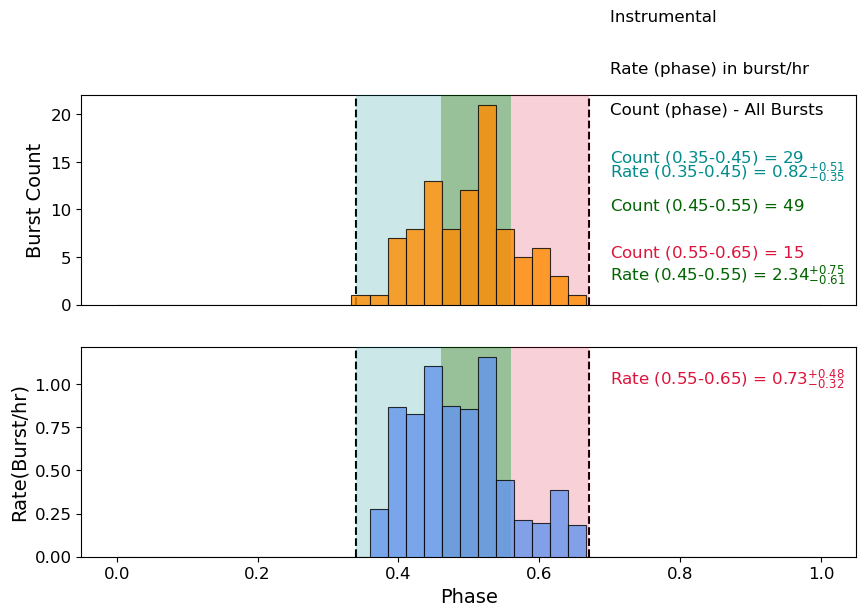

In [29]:
##### To show all burst count as well #####
##### Phase vs cycle #####
obs_phases = fold_data(period, ref_mjd, mjd_obs_dates, True) #### Phases between 0 and 1
#nbin = 41
nbin = 40
exp_phases = get_phase_exposure(exp_u, obs_phases, nbin)
#print(exp_phases)

sens_phases = get_phase_sens(sens_u, obs_phases, nbin)
#sens_phases = sens_phases[0:nbin-1]
sens_phases = sens_phases[0:nbin]

f_thresh_phases = (sens_phases/sens_overall) * 5.2


#exp_phases = (exp_phases[0:nbin-1])/60
exp_phases = (exp_phases[0:nbin])/60

burst_phases = fold_data(period, ref_mjd, mjd_remove, True)
burst_phases_all = fold_data(period, ref_mjd, mjd_all, True)
print(burst_phases_all.shape)

n=np.linspace(0,1,nbin)
bin_width = n[1]-n[0]


hist = np.histogram(burst_phases, bins=n)
hist_all = np.histogram(burst_phases_all, bins=n)
print(hist_all)
print(np.sum(hist_all[0]))
# for i in range(len(hist[0])):
#     print(hist[0][i], hist[1][i])

#rate_phases = hist_all[0]/exp_phases
rate_phases = hist[0]/exp_phases
### Scaling the phase to 5.2 Jy ms #####
rate_phases = scale_rate(rate_phases,f_thresh_phases)


rate_phases_low = rate_phases - (get_poisson_error(hist[0], conf_level=0.95)[0])/exp_phases
rate_phases_high = (get_poisson_error(hist[0], conf_level=0.95)[1])/exp_phases - rate_phases

##### Calculating rates at each phase range along with errors ####

left_ind = np.where(np.logical_and(n>=0.35, n<=0.45))
print("Left ind", left_ind)
mid_ind = np.where(np.logical_and(n>=0.45, n<=0.55))
print("Mid ind", mid_ind)
right_ind = np.where(np.logical_and(n>=0.55, n<=0.65))
print("Right ind", right_ind)

#### Left range #######

lmin, lmax = np.min(left_ind), np.max(left_ind)+1
print("Lmin, Lmax", lmin, lmax)
burst_l = np.sum(hist[0][lmin:lmax])
burst_all_l = np.sum(hist_all[0][lmin:lmax])
print("Excised_bursts", burst_l)
exp_l = np.sum(exp_phases[lmin:lmax])
print("Exposure", exp_l)

# ratel_val = burst_all_l/exp_l
# ratel_lo = ratel_val - (get_poisson_error(burst_all_l, conf_level=0.95)[0])/exp_l
# ratel_hi = (get_poisson_error(burst_all_l, conf_level=0.95)[1])/exp_l - ratel_val 

ratel_val = burst_l/exp_l
ratel_lo = ratel_val - (get_poisson_error(burst_l, conf_level=0.95)[0])/exp_l
ratel_hi = (get_poisson_error(burst_l, conf_level=0.95)[1])/exp_l - ratel_val 
print(ratel_lo, ratel_val, ratel_hi)

# ratel_lo, ratel_val, ratel_hi = np.mean(rate_phases_low[lmin:lmax]), np.mean(rate_phases[lmin:lmax]), np.mean(rate_phases_high[lmin:lmax])
# print(ratel_lo, ratel_val, ratel_hi, "\n")

#### middle range #####

mmin, mmax = np.min(mid_ind), np.max(mid_ind)+1
print("Mmin, Mmax", mmin, mmax)
burst_m = np.sum(hist[0][mmin:mmax])
burst_all_m = np.sum(hist_all[0][mmin:mmax])
print("Excised_bursts", burst_m)
exp_m = np.sum(exp_phases[mmin:mmax])
print("Exposure", exp_m)

ratem_val = burst_all_m/exp_m
ratem_lo = ratem_val - (get_poisson_error(burst_all_m, conf_level=0.95)[0])/exp_m
ratem_hi = (get_poisson_error(burst_all_m, conf_level=0.95)[1])/exp_m - ratem_val 
print(ratem_lo, ratem_val, ratem_hi)

# ratem_lo, ratem_val, ratem_hi = np.mean(rate_phases_low[mmin:mmax]), np.mean(rate_phases[mmin:mmax]), np.mean(rate_phases_high[mmin:mmax])
# print(ratem_lo, ratem_val, ratem_hi, "\n")

#### right range ####

rmin, rmax = np.min(right_ind), np.max(right_ind)+1
print("Rmin, Rmax", rmin, rmax)
burst_r = np.sum(hist[0][rmin:rmax])
burst_all_r = np.sum(hist_all[0][rmin:rmax])
print("Excised_bursts", burst_r)
exp_r = np.sum(exp_phases[rmin:rmax])
print("Exposure", exp_r)

rater_val = burst_all_r/exp_r
rater_lo = rater_val - (get_poisson_error(burst_all_r, conf_level=0.95)[0])/exp_r
rater_hi = (get_poisson_error(burst_all_r, conf_level=0.95)[1])/exp_r - rater_val 
print(rater_lo, rater_val, rater_hi)

# rater_lo, rater_val, rater_hi = np.mean(rate_phases_low[rmin:rmax]), np.mean(rate_phases[rmin:rmax]), np.mean(rate_phases_high[rmin:rmax])
# print(rater_lo, rater_val, rater_hi)

###### Plotting #########

fig, axs = plt.subplots(2, 1, figsize=(10,6))

axs[0].bar(n[0:nbin-1],hist_all[0], bin_width, align='edge', 
        alpha=0.8, edgecolor='black', color='DarkOrange', linewidth=0.8, zorder=20)
axs[0].set(xlabel=None)
axs[0].set_xticks([])


axs[0].axvspan(0.34,0.46, facecolor = 'darkcyan', alpha = 0.2, zorder = 11)
axs[0].axvspan(0.46,0.56, facecolor = 'darkgreen', alpha = 0.4, zorder = 10)
axs[0].axvspan(0.56,0.67, facecolor = 'crimson', alpha = 0.2, zorder = 12)


axs[0].text(x=0.7, y = 20, s=r"Count (phase) - All Bursts ", fontsize=12, color = 'k')

axs[0].text(x=0.7, y = 15, s=r"Count (0.35-0.45) = ${}$".format(burst_all_l), fontsize=12, color = 'darkcyan')
axs[0].text(x=0.7, y = 10, s=r"Count (0.45-0.55) = ${}$".format(burst_all_m), fontsize=12, color = 'darkgreen')
axs[0].text(x=0.7, y = 5, s=r"Count (0.55-0.65) = ${}$".format(burst_all_r), fontsize=12, color = 'crimson')

axs[0].axvline(0.34, color='k', linestyle='--')
axs[0].axvline(0.67, color='k', linestyle='--')

axs[0].set_ylabel("Burst Count", fontsize = 14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].tick_params(axis='both', which='minor', labelsize=12)

axs[1].bar(n[0:nbin-1],rate_phases,bin_width ,align='edge', 
        alpha=0.8, edgecolor='black', color='cornflowerblue', linewidth=0.8, zorder=20)


#plt.axvspan(0.37,0.68, facecolor = 'gray', alpha = 0.2, zorder = 9)

# plt.text(x=0.7, y = 1.5, s=r"Rate (phase) in burst/hr ", fontsize=12, color = 'k')

# plt.text(x=0.7, y = 1.2, s=r"Rate (0.35-0.45) = ${}^{{+{}}}_{{-{}}}$".format(ratel_val.round(2), ratel_hi.round(2), ratel_lo.round(2)), 
#          fontsize=12, color = 'darkcyan')
# plt.text(x=0.7, y = 0.9, s=r"Rate (0.45-0.55) = ${}^{{+{}}}_{{-{}}}$".format(ratem_val.round(2), ratem_hi.round(2), ratem_lo.round(2)), 
#          fontsize=12, color = 'darkgreen')
# plt.text(x=0.7, y = 0.6, s=r"Rate (0.55-0.65) = ${}^{{+{}}}_{{-{}}}$".format(rater_val.round(2), rater_hi.round(2), rater_lo.round(2)), 
#          fontsize=12, color = 'crimson')

###### Bin change #######

axs[1].text(x=0.7, y = 3.1, s=r"Instrumental ", fontsize=12, color = 'k')
axs[1].text(x=0.7, y = 2.8, s=r"Rate (phase) in burst/hr ", fontsize=12, color = 'k')

axs[1].text(x=0.7, y = 2.2, s=r"Rate (0.35-0.45) = ${}^{{+{}}}_{{-{}}}$".format(ratel_val.round(2), ratel_hi.round(2), ratel_lo.round(2)), 
         fontsize=12, color = 'darkcyan')
axs[1].text(x=0.7, y = 1.6, s=r"Rate (0.45-0.55) = ${}^{{+{}}}_{{-{}}}$".format(ratem_val.round(2), ratem_hi.round(2), ratem_lo.round(2)), 
         fontsize=12, color = 'darkgreen')
axs[1].text(x=0.7, y = 1.0, s=r"Rate (0.55-0.65) = ${}^{{+{}}}_{{-{}}}$".format(rater_val.round(2), rater_hi.round(2), rater_lo.round(2)), 
         fontsize=12, color = 'crimson')

axs[1].axvspan(0.34,0.46, facecolor = 'darkcyan', alpha = 0.2, zorder = 11)
axs[1].axvspan(0.46,0.56, facecolor = 'darkgreen', alpha = 0.4, zorder = 10)
axs[1].axvspan(0.56,0.67, facecolor = 'crimson', alpha = 0.2, zorder = 12)

axs[1].axvline(0.34, color='k', linestyle='--')
axs[1].axvline(0.67, color='k', linestyle='--')

axs[1].set_xlabel("Phase", fontsize = 14)
axs[1].set_ylabel("Rate(Burst/hr)", fontsize = 14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='minor', labelsize=12)
#plt.savefig("Final_plots/All_count_rate_phase.pdf", dpi=300, bbox_inches='tight')
plt.show()


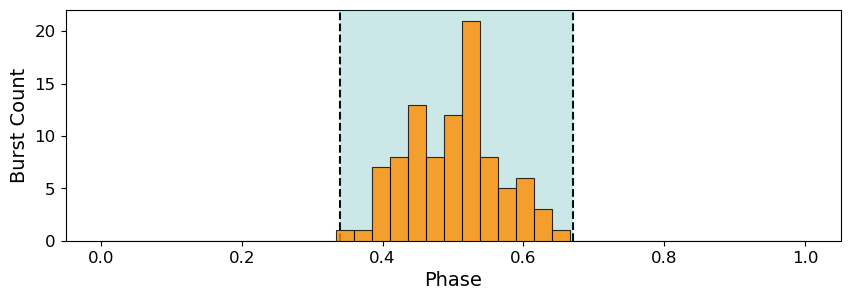

In [37]:
fig = plt.figure(figsize=(10,3))

plt.bar(n[0:nbin-1],hist_all[0], bin_width, align='edge', 
        alpha=0.8, edgecolor='black', color='DarkOrange', linewidth=0.8, zorder=20)



plt.axvspan(0.34,0.67, facecolor = 'darkcyan', alpha = 0.2, zorder = 11)
# plt.axvspan(0.46,0.56, facecolor = 'darkgreen', alpha = 0.4, zorder = 10)
# plt.axvspan(0.56,0.67, facecolor = 'crimson', alpha = 0.2, zorder = 12)


# plt.text(x=0.7, y = 20, s=r"Count (phase) - All Bursts ", fontsize=12, color = 'k')

# plt.text(x=0.7, y = 15, s=r"Count (0.35-0.45) = ${}$".format(burst_all_l), fontsize=12, color = 'darkcyan')
# plt.text(x=0.7, y = 10, s=r"Count (0.45-0.55) = ${}$".format(burst_all_m), fontsize=12, color = 'darkgreen')
# plt.text(x=0.7, y = 5, s=r"Count (0.55-0.65) = ${}$".format(burst_all_r), fontsize=12, color = 'crimson')

plt.axvline(0.34, color='k', linestyle='--')
plt.axvline(0.67, color='k', linestyle='--')

plt.ylabel("Burst Count", fontsize = 14)
plt.xlabel("Phase", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Final_plots/All_count_phase.jpg", dpi=300, bbox_inches='tight')
plt.show()

# axs[0].tick_params(axis='both', which='major', labelsize=12)
# axs[0].tick_params(axis='both', which='minor', labelsize=12)

KS test = 0.13513513513513514, p value = 0.5116809114588617
KS test = 0.02702702702702703, p value = 0.9999999999999987
KS test = 0.3108108108108108, p value = 0.0014667074029002314
Median of p is 0.5116809114588617


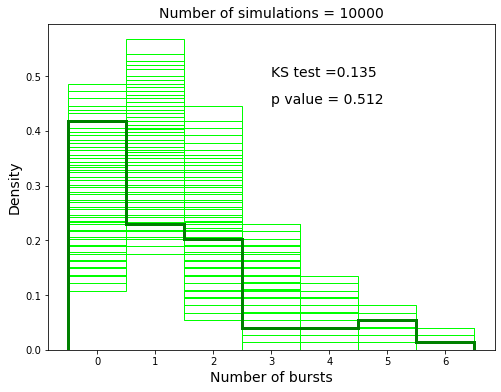

0

In [120]:
'''To check whether the count distribution is poissonian or not. I took the original distribution and compared
it using KS-test to simulated poisson distribution. The simulated distribution has a lambda of mean of original distribution
if the p-value is less than 0.1 then we can say two distribution differ if not then two are the same. Here we are
proving that two are the same. Dark is the main and light are simulated values'''


bc_all = burst_count_all
bc_remove = burst_count_remove
bc_all_low, bc_all_high = get_poisson_error(bc_all, 0.95)
bc_remove_low, bc_remove_high = get_poisson_error(bc_remove, 0.95)

plt.figure(figsize=(8,6))

hist1 = plt.hist(bc_all, bins=nc, density=True, histtype='step', color='green', zorder=90, linewidth=3)
nsim = 10000
ks_val = np.zeros(nsim)
p_val = np.zeros(nsim)
for i in range(nsim):
    x = poisson.rvs(mu=np.mean(bc_all), size=max_cycle)
    hist2 = plt.hist(x, bins=nc, density=True, histtype='step',color='lime')#alpha=1)
    ks = ks_2samp(bc_all, x)
    ks_val[i] = ks[0]
    p_val[i] = ks[1]
    

# med_ind = np.where(np.percentile(ks_val, 50) == ks_val)
# low_ind = np.where(np.percentile(ks_val, 1) == ks_val)
# high_ind = np.where(np.percentile(ks_val, 99) == ks_val)

plt.xlabel("Number of bursts", fontsize=14)
plt.ylabel("Density", fontsize=14)

med_ind = np.where(np.median(ks_val) == ks_val)
med_p = np.median(p_val) 
low_ind = np.where(np.min(ks_val) == ks_val)
high_ind = np.where(np.max(ks_val) == ks_val)

print("KS test = {}, p value = {}".format(ks_val[med_ind][0], p_val[med_ind][0]))
print("KS test = {}, p value = {}".format(ks_val[low_ind][0], p_val[low_ind][0]))
print("KS test = {}, p value = {}".format(ks_val[high_ind][0], p_val[high_ind][0]))
print("Median of p is", med_p)

plt.text(3,0.5,"KS test ={}".format(ks_val[med_ind][0].round(3)), fontsize=14)
plt.text(3,0.45,"p value = {}".format(p_val[med_ind][0].round(3)), fontsize=14)
plt.title("Number of simulations = {}".format(nsim), fontsize=14)
plt.show()

gc.collect()

In [ ]:
'''You can compare the burst rate with energy and put constraints on the model. Calculate roughly the energy 
of typical R3 bursts and using the rate talk about the source energy reservoir'''

In [35]:
t = 10000 
p = 16.3
pdot = p/(t*365)
print(pdot)

4.465753424657535e-06
